In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('cle.csv')
df.head()

,Unnamed: 0,x,lat,lon,M2TMNXSLV_5_12_4_T10M,M2SMNXPCT_2_PRECTOT,M2TMNXSLV_5_12_4_CLDTMP
0,0,2023-04-02T01:00:00Z,22.0,25.000,296.13623,51.453106,241.39410
1,1,2023-04-02T04:00:00Z,22.0,25.000,296.13623,51.453106,241.39410
2,2,2023-04-02T07:00:00Z,22.0,25.000,296.13623,51.453106,241.39410
3,3,2023-04-02T10:00:00Z,22.0,25.000,296.13623,51.453106,241.39410
4,4,2023-04-02T13:00:00Z,22.0,25.625,295.45517,51.608845,242.35434


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
df.isnull().sum()

x                          0
lat                        0
lon                        0
M2TMNXSLV_5_12_4_T10M      0
M2SMNXPCT_2_PRECTOT        0
M2TMNXSLV_5_12_4_CLDTMP    0
dtype: int64

In [5]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
3708     True
3709    False
3710     True
3711    False
3712    False
Length: 3713, dtype: bool

In [6]:
df=df.drop_duplicates()

In [7]:
df.columns

Index(['x', 'lat', 'lon', 'M2TMNXSLV_5_12_4_T10M', 'M2SMNXPCT_2_PRECTOT',
       'M2TMNXSLV_5_12_4_CLDTMP'],
      dtype='object')

In [8]:
df["x"] = pd.to_datetime(df["x"])

In [9]:
df['year'] = df['x'].dt.year
df['month'] = df['x'].dt.month
df['day'] = df['x'].dt.day

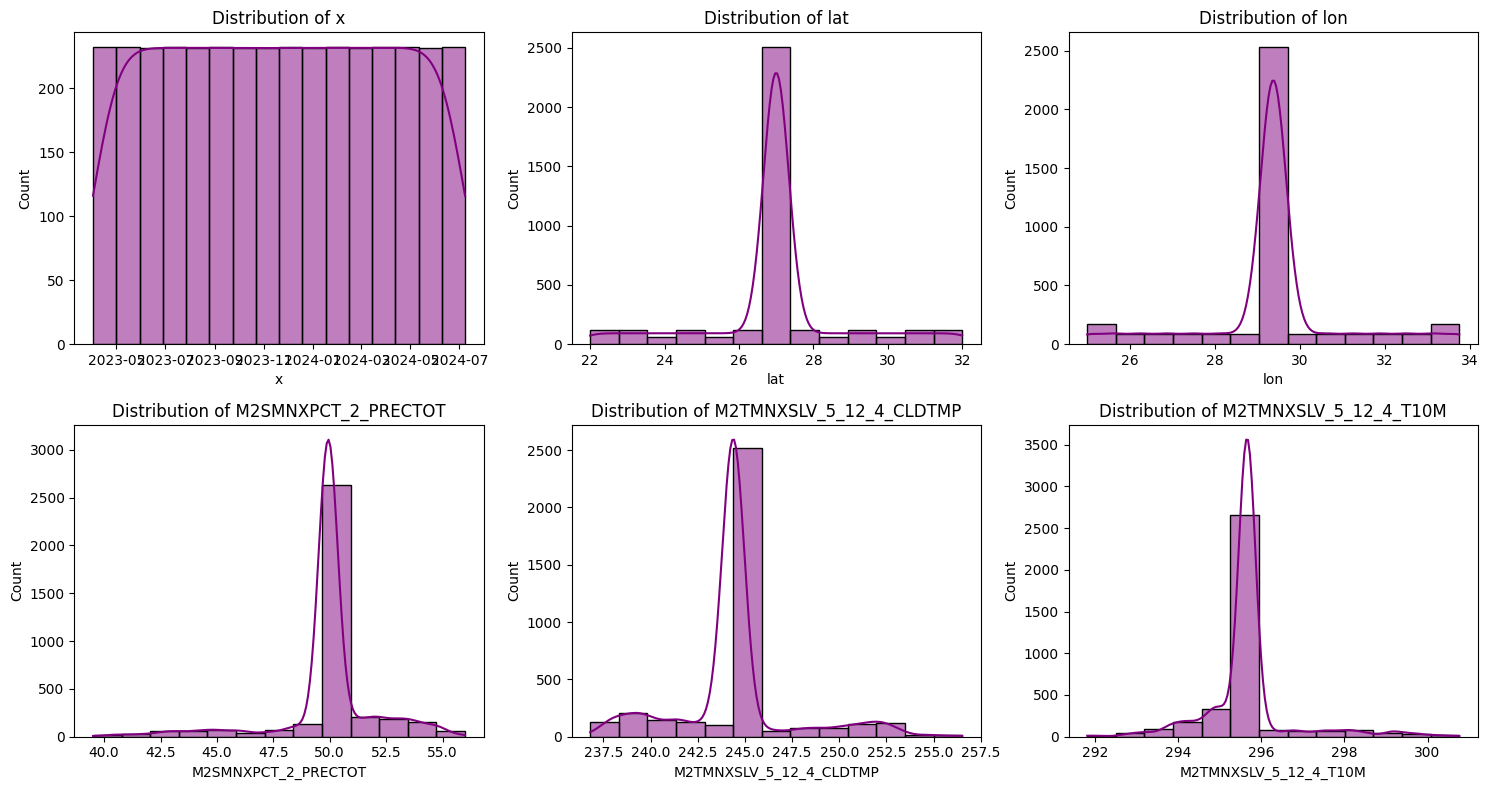

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['x',"lat", "lon","M2SMNXPCT_2_PRECTOT","M2TMNXSLV_5_12_4_CLDTMP","M2TMNXSLV_5_12_4_T10M"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i],color='purple')
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


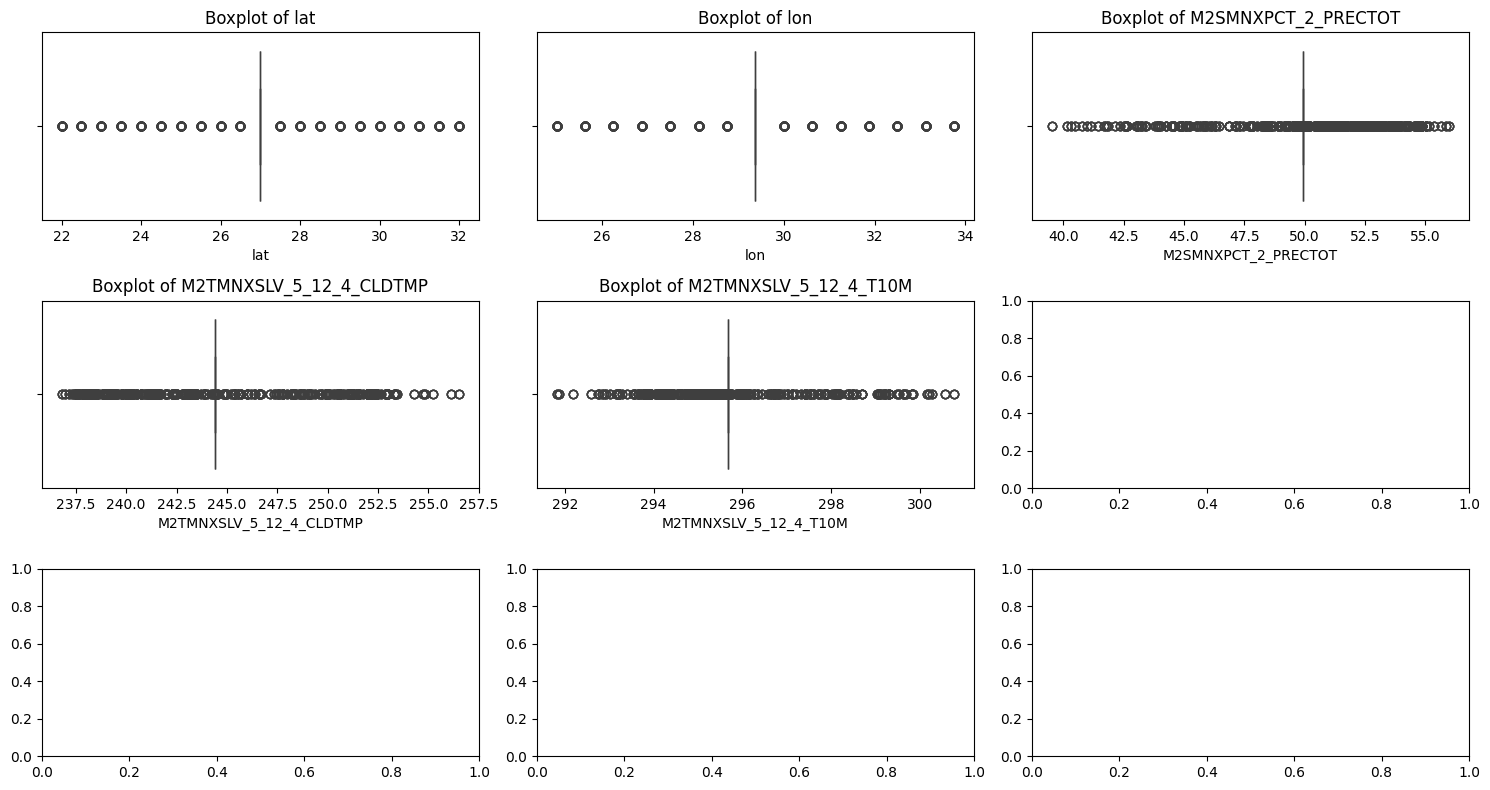

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ["lat", "lon","M2SMNXPCT_2_PRECTOT","M2TMNXSLV_5_12_4_CLDTMP","M2TMNXSLV_5_12_4_T10M"]

fig, axes = plt.subplots(3, 3, figsize=(15, 8))

axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


In [12]:
cols = ["lat", "lon","M2SMNXPCT_2_PRECTOT","M2TMNXSLV_5_12_4_CLDTMP","M2SMNXPCT_2_PRECTOT"]

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

print("Number of outliers before capping:")
for col in cols:
    print(f"{col}: {count_outliers(df[col])}")



Number of outliers before capping:
lat: 1200
lon: 1176
M2SMNXPCT_2_PRECTOT: 1260
M2TMNXSLV_5_12_4_CLDTMP: 1260
M2SMNXPCT_2_PRECTOT: 1260


In [16]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb

# فصل الهدف عن المتغيرات
X = df.drop(["M2SMNXPCT_2_PRECTOT","M2TMNXSLV_5_12_4_CLDTMP","M2TMNXSLV_5_12_4_T10M"], axis=1)
y = df["M2TMNXSLV_5_12_4_T10M"]

# الأعمدة الرقمية فقط (بدون الهدف)
cols = ["lat", "lon",'year', 'month', 'day']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cols)
    ]
)

# النماذج
models = {
    "LinearRegression": (
        Pipeline([("preprocessor", preprocessor), ("model", LinearRegression())]),
        {}
    ),
    "DecisionTree": (
        Pipeline([("preprocessor", preprocessor), ("model", DecisionTreeRegressor(random_state=42))]),
        {"model__max_depth": [None, 5, 10], "model__min_samples_split": [2, 5]}
    ),
    "RandomForest": (
        Pipeline([("preprocessor", preprocessor), ("model", RandomForestRegressor(random_state=42))]),
        {"model__n_estimators": [50, 100], "model__max_depth": [None, 5, 10]}
    ),
    "KNN": (
        Pipeline([("preprocessor", preprocessor), ("model", KNeighborsRegressor())]),
        {"model__n_neighbors": list(range(2, 21)), "model__weights": ["uniform", "distance"]}
    ),
    "SVR": (
        Pipeline([("preprocessor", preprocessor), ("model", SVR())]),
        {"model__C": [0.1, 1, 10], "model__kernel": ["linear", "rbf"], "model__gamma": ["scale", "auto"]}
    ),
    "XGBRegressor": (
        Pipeline([("preprocessor", preprocessor), ("model", xgb.XGBRegressor(objective="reg:squarederror", random_state=42))]),
        {"model__n_estimators": [100, 200], "model__max_depth": [3, 5, 7], "model__learning_rate": [0.01, 0.1, 0.2]}
    ),
}

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = []

# التدريب والتقييم
for name, (model, params) in models.items():
    print(f"\n===== {name} =====")

    if params:
        grid = GridSearchCV(model, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        best_params = {}

    # توقع على train و test
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # حساب المقاييس
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)

    print("Best Params:", best_params if best_params else "Default")
    print(f"Train -> RMSE: {rmse_train:.3f}, R²: {r2_train:.3f}")
    print(f"Test  -> RMSE: {rmse_test:.3f}, R²: {r2_test:.3f}")

    results.append({
        "Model": name,
        "Best Params": best_params if best_params else "Default",
        "Train RMSE": rmse_train, "Train R²": r2_train,
        "Test RMSE": rmse_test, "Test R²": r2_test
    })

# عرض النتائج في جدول مرتب
results_df = pd.DataFrame(results)
print("\n===== Summary =====")
print(results_df.sort_values(by="Test RMSE"))



===== LinearRegression =====
Best Params: Default
Train -> RMSE: 0.594, R²: 0.648
Test  -> RMSE: 0.623, R²: 0.699

===== DecisionTree =====
Best Params: {'model__max_depth': None, 'model__min_samples_split': 2}
Train -> RMSE: 0.000, R²: 1.000
Test  -> RMSE: 0.000, R²: 1.000

===== RandomForest =====
Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
Train -> RMSE: 0.021, R²: 1.000
Test  -> RMSE: 0.038, R²: 0.999

===== KNN =====
Best Params: {'model__n_neighbors': 16, 'model__weights': 'distance'}
Train -> RMSE: 0.000, R²: 1.000
Test  -> RMSE: 0.000, R²: 1.000

===== SVR =====
Best Params: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Train -> RMSE: 0.312, R²: 0.903
Test  -> RMSE: 0.287, R²: 0.936

===== XGBRegressor =====
Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200}
Train -> RMSE: 0.017, R²: 1.000
Test  -> RMSE: 0.021, R²: 1.000

===== Summary =====
              Model                                

In [14]:
import joblib

joblib.dump(best_model, "xgb_Temp_model.pkl")
joblib.dump(grid.best_estimator_, "rf_Temp_model.pkl")



['rf_Temp_model.pkl']

In [20]:
import numpy as np
import pandas as pd
import joblib

# تحميل الموديل
model = joblib.load("rf_Temp_model.pkl")

# نفس الأعمدة اللي اتدرب عليها الموديل
cols = ["lat", "lon", "year", "month", "day"]

# بيانات جديدة للتجربة
new_data = pd.DataFrame([
    {"lat": 28.75, "lon": 30.50, "year": 2028, "month": 4, "day": 3},
    {"lat": 31.20, "lon": 29.95, "year": 2024, "month": 10, "day": 4},
    {"lat": 27.50, "lon": 32.10, "year": 2024, "month": 10, "day": 5}
])

# التنبؤ
prediction = model.predict(new_data)
print("Predictions:", prediction)


Predictions: [294.71976 294.03833 295.38928]
